# Keras costs visualizations
In this notebook we will visualize different costs associated with different popular architectures

## Define functions

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import json

In [3]:
def print_report_info(report_path):
    with open(report_path) as file: 
        report = json.load(file)
    print("{:15}: {}".format("host",report["host"]))
    for item in report["args"].items():
        print("{:15}: {}".format(*item))

In [4]:
time_unit_label = "us"
time_multiplier=1e3
def preprocess_layer_cost_data(report, layer_name, cost_name, plot_total_costs=False,
                              skip_first_batch = False, skip_first_batch_in_each_trial=False,
                              suppress_warnings = False):
    timings = report["timings"]
    
    if "samples" in report["args"]:
        total_num_of_records = report["args"]["trials"]
        normalizing_factor = report["args"]["samples"] * time_multiplier
    else:
        total_num_of_records = report["args"]["trials"]*report["args"]["num_of_batches"]
        normalizing_factor = report["args"]["batch_size"]*report["args"]["num_of_batches"] * time_multiplier
    data = timings[layer_name][cost_name]
    if isinstance(data, dict):
        if plot_total_costs:
            data = data["total_time_costs"]
        else:
            data = data["durations"]
    if len(data) < total_num_of_records and not suppress_warnings:
        print("Warning! The report has {}/{} records for {} {}".format(len(data), total_num_of_records,
                                                                       layer_name, cost_name))
    if skip_first_batch_in_each_trial:
        for i in range(report["args"]["trials"]):
            i_to_remove = i*report["args"]["num_of_batches"] - i
            if i_to_remove >= len(data):  # Missing some records
                break
            data.pop(i_to_remove)
    elif skip_first_batch:
        data = data[1:]
    data = np.array(data) / normalizing_factor
    return data

### Observe layer cost vs trial
For debugging purposes the cost should be almost constant

In [5]:
def plot_cost_vs_time(report_path, title=None, cols=2, skip_first_layer=False, plot_total_costs=False,
                      skip_first_batch = False, skip_first_batch_in_each_trial=False, suppress_warnings=False):
    with open(report_path) as file: 
        report = json.load(file)
    timings = report["timings"]
    costs = set(list(timings.values())[0].keys()) - {"Type"}
    plt.figure(figsize=(16,4 * np.ceil(len(costs)/cols)))
    c = 1
    for cost_name in costs:
        import math
        plt.subplot(np.ceil(len(costs)/cols), cols, c)
        c += 1
        for layer_name in list(timings.keys())[(1 if skip_first_layer else 0):]:
            data = preprocess_layer_cost_data(report, layer_name, cost_name, suppress_warnings=suppress_warnings,
                                              plot_total_costs=plot_total_costs,
                                              skip_first_batch=skip_first_batch,
                                              skip_first_batch_in_each_trial=skip_first_batch_in_each_trial
                                             )
            plt.plot(range(len(data)),  data, label=layer_name)
        plt.xlabel("Batch NO")
        plt.ylabel("Time per batch (us)")
        plt.xticks(range(len(data)))
        #plt.legend()
        if title == "":
            plt.title(cost_name)
        else:
            plt.title("{}: {}".format(title if title else report_path, cost_name))
    plt.show()

### Layer wise costs

In [6]:
costs = ["data_generation_cost", "forward_pass_cost", "backward_pass_cost", "output_calculation_cost",
         "loss_calculation_cost","gradient_calculation_cost", "gradient_application_cost", "predict",
         "evaluate","fit"]
def plot_layer_wise_costs(report_path, title=None, skip_first_layer=False, stacked=False, width=0.7,
                          skip_first_batch = False, skip_first_batch_in_each_trial=False,
                          plot_total_costs=False, suppress_warnings = False):
    with open(report_path) as file: 
        report = json.load(file)
    timings = report["timings"]
    N = len(timings) - (1 if skip_first_layer else 0)
    means = dict()
    stds = dict()
    xticks = list()
    for layer_name in list(timings.keys())[(1 if skip_first_layer else 0):]:
        for cost_name in costs:
            if not cost_name in timings[layer_name].keys():
                continue
            if cost_name not in means.keys():
                means[cost_name] = list()
            if cost_name not in stds.keys():
                stds[cost_name] = list()
            data = preprocess_layer_cost_data(report, layer_name, cost_name, suppress_warnings=suppress_warnings,
                                              plot_total_costs=plot_total_costs,
                                              skip_first_batch=skip_first_batch,
                                              skip_first_batch_in_each_trial=skip_first_batch_in_each_trial
                                             )
            means[cost_name].append(np.mean(data))
            stds[cost_name].append(np.std(data))
        xticks.append(layer_name)

    plt.figure(figsize=(200,20))
    ind = np.arange(N)    # the x locations for the groups
    
    if stacked:
        accumulated_means = np.zeros(shape=N)
        for cost in means.keys():
            p = plt.bar(ind, means[cost], width, yerr=stds[cost], bottom=accumulated_means, label=cost)
            accumulated_means += means[cost]
    else:
        n = len(means)
        for j, cost in enumerate(means.keys()):
            p = plt.bar(ind - width/2 + width/n*j, means[cost], width/n, yerr=stds[cost], label=cost)
    plt.ylabel('Time per batch (us)')
    plt.xlabel("Last added layer")
    if title == "":
        plt.title(cost_name)
    else:
        plt.title("{}: {}".format(title if title else report_path, cost_name))
    plt.xticks(ind, xticks, rotation="vertical")
    plt.legend()
    plt.axhline(0, color='black')
    plt.show()

## Visualize reports

host           : mcnode38
model          : ResNet50
loss           : binary_crossentropy
eager          : False
optimizer      : sgd
device         : cpu
batch_size     : 8
num_of_batches : 10
trials         : 4
skip           : False
use_python_timing: False
out            : None
log            : None


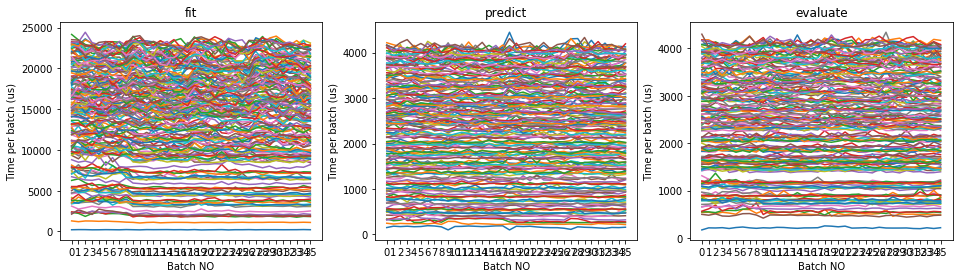

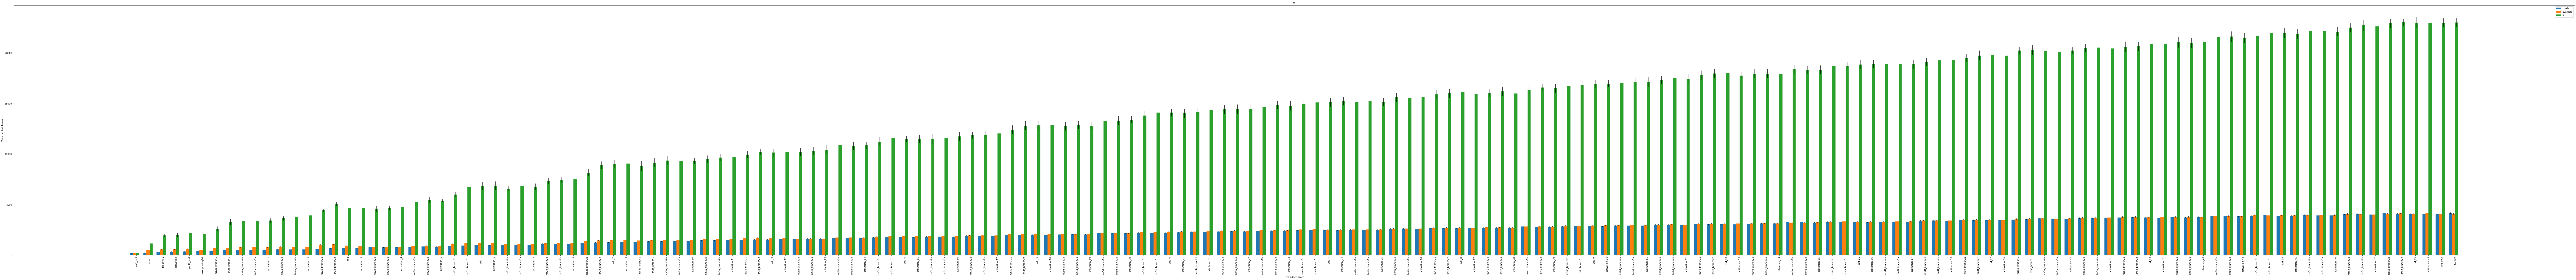

In [7]:
report_path = "timings/ResNet50_07-02-20-37.timings.json"
print_report_info(report_path)
plot_cost_vs_time(report_path,title="", cols=3, skip_first_batch_in_each_trial=True, suppress_warnings=True)
plot_layer_wise_costs(report_path, title="", skip_first_batch_in_each_trial = True, suppress_warnings=True)

host           : mcnode39
model          : InceptionV3
loss           : binary_crossentropy
eager          : False
optimizer      : sgd
device         : cpu
batch_size     : 8
num_of_batches : 10
trials         : 1
skip           : False
use_python_timing: False
out            : None
log            : None


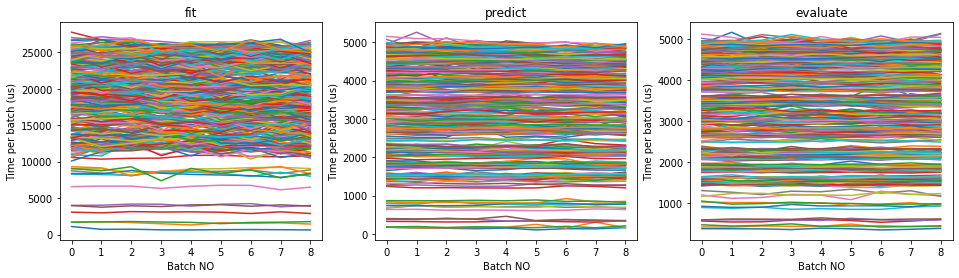

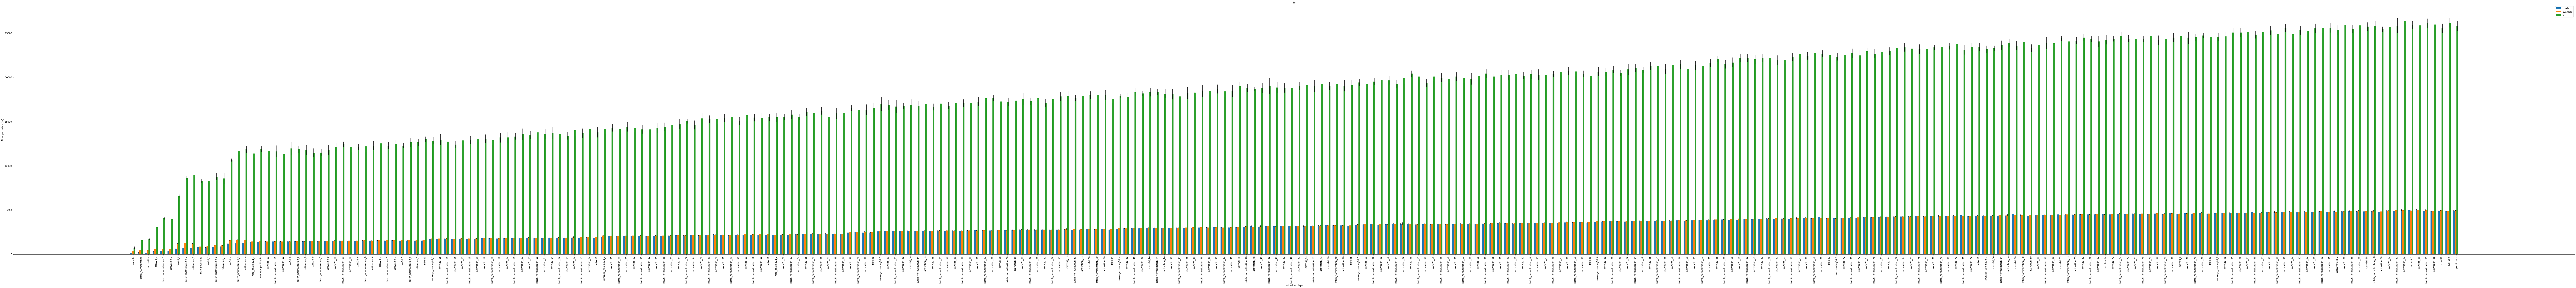

In [9]:
report_path = "timings/InceptionV3_07-02-21-21.timings.json"
print_report_info(report_path)
plot_cost_vs_time(report_path,title="", cols=3, skip_first_batch_in_each_trial=True, suppress_warnings=True)
plot_layer_wise_costs(report_path, title="", skip_first_batch_in_each_trial = True, suppress_warnings=True)

host           : mcnode40
model          : DenseNet121
loss           : binary_crossentropy
eager          : False
optimizer      : sgd
device         : cpu
batch_size     : 8
num_of_batches : 10
trials         : 1
skip           : False
use_python_timing: False
out            : None
log            : None


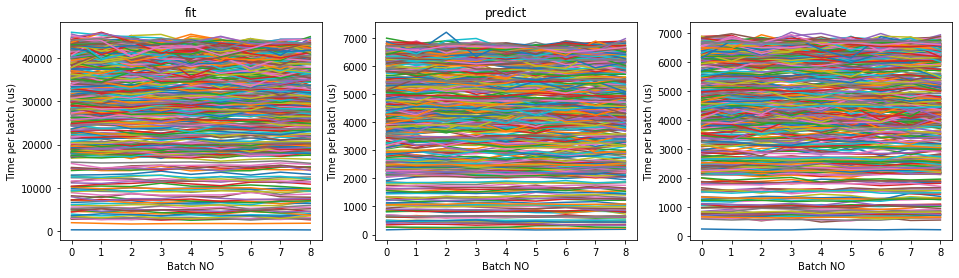

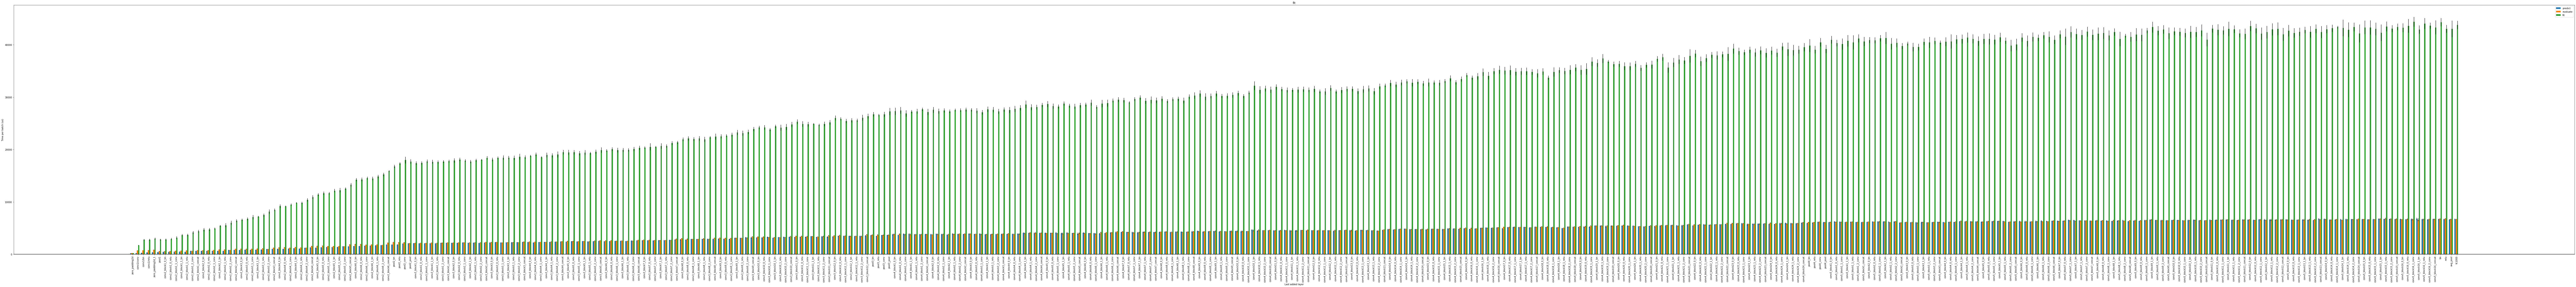

In [10]:
report_path = "timings/DenseNet121_07-03-08-48.timings.json"
print_report_info(report_path)
plot_cost_vs_time(report_path,title="", cols=3, skip_first_batch_in_each_trial=True, suppress_warnings=True)
plot_layer_wise_costs(report_path, title="", skip_first_batch_in_each_trial = True, suppress_warnings=True)